In [1]:
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
import os
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
def load_rtstruct(rtstruct_path):
    """Loads RTSTRUCT DICOM file and extracts tumor contours"""
    rtstruct = pydicom.dcmread(rtstruct_path)
    
    # Map ROINumber to ROIName
    roi_map = {
        roi.ROINumber: roi.ROIName for roi in rtstruct.StructureSetROISequence
    }
    print("Available ROIs:", roi_map)
    
    return rtstruct, roi_map

def load_ct_images(ct_dir):
    """Loads all CT DICOM images from the given directory and sorts them by InstanceNumber"""
    ct_slices = []
    for file in os.listdir(ct_dir):
        if file.endswith(".dcm"):
            dicom_path = os.path.join(ct_dir, file)
            dicom_data = pydicom.dcmread(dicom_path)
            ct_slices.append(dicom_data)
    
    # Sort slices based on Instance Number to ensure correct order
    ct_slices.sort(key=lambda x: int(x.InstanceNumber))
    print(f"Loaded {len(ct_slices)} CT slices.")
    return ct_slices




def read_dicom_image(dicom):
    """Reads and normalizes a DICOM image while maintaining original contrast"""
    img = dicom.pixel_array
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)
    return img

def extract_tumor_bboxes(rtstruct, roi_map, ct_slices, roi_name="GTV-1"):
    """Extracts tumor contours from RTSTRUCT and converts them into bounding boxes."""
    bboxes = []
    
    # Find the ROINumber for the given ROIName
    roi_number = None
    for num, name in roi_map.items():
        if name == roi_name:
            roi_number = num
            break
    
    if roi_number is None:
        print(f"ROI '{roi_name}' not found!")
        return None
    
    for roi in rtstruct.ROIContourSequence:
        if roi.ReferencedROINumber == roi_number:
            for contour in roi.ContourSequence:
                points = np.array(contour.ContourData).reshape(-1, 3)  # Extract (x, y, z)
                z_pos = points[0, 2]  # Get the Z slice position
                
                # Find closest slice
                z_slice_idx = min(range(len(ct_slices)), key=lambda i: abs(ct_slices[i].ImagePositionPatient[2] - z_pos))
                pixel_spacing = np.array(ct_slices[z_slice_idx].PixelSpacing)
                origin = np.array(ct_slices[z_slice_idx].ImagePositionPatient[:2])
                
                # Convert contour points to pixel coordinates
                points[:, :2] = (points[:, :2] - origin) / pixel_spacing[::-1]  # Swap order for correct mapping
                x_min, y_min = np.min(points[:, :2], axis=0)
                x_max, y_max = np.max(points[:, :2], axis=0)
                
                # Store bounding box
                bboxes.append((z_slice_idx, int(x_min), int(y_min), int(x_max), int(y_max)))
    
    return bboxes

def visualize_bboxes(ct_slices, bboxes):
    """Visualizes bounding boxes on CT slices while maintaining original grayscale contrast."""
    for z_idx, x_min, y_min, x_max, y_max in bboxes:
        image = read_dicom_image(ct_slices[z_idx])  # Normalize without altering contrast
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        
        plt.figure()
        plt.imshow(image, cmap="gray")
        plt.title(f"Slice {z_idx} - Tumor Bounding Box")
        plt.show()

# File paths (adjust accordingly)
rtstruct_path = "/Users/catarinasilva/Desktop/NSCLC data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/4.000000-NA-45931/1-1.dcm"
ct_dir = "/Users/catarinasilva/Desktop/NSCLC data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-002/01-01-2014-StudyID-NA-85095/1.000000-NA-61228"

# Load RTSTRUCT and CT images
rtstruct, roi_map = load_rtstruct(rtstruct_path)
ct_slices = load_ct_images(ct_dir)

# Extract and visualize bounding boxes
bboxes = extract_tumor_bboxes(rtstruct, roi_map, ct_slices)
if bboxes:
    visualize_bboxes(ct_slices, bboxes)


In [ ]:
def load_rtstruct(rtstruct_path):
    """Loads RTSTRUCT DICOM file and extracts tumor contours"""
    rtstruct = pydicom.dcmread(rtstruct_path)
    
    # Map ROINumber to ROIName
    roi_map = {
        roi.ROINumber: roi.ROIName for roi in rtstruct.StructureSetROISequence
    }
    print("Available ROIs:", roi_map)
    
    return rtstruct, roi_map

def load_ct_images(ct_dir):
    """Loads all CT DICOM images from the given directory and sorts them by InstanceNumber"""
    ct_slices = []
    for file in os.listdir(ct_dir):
        if file.endswith(".dcm"):
            dicom_path = os.path.join(ct_dir, file)
            dicom_data = pydicom.dcmread(dicom_path)
            ct_slices.append(dicom_data)
    
    # Sort slices based on Instance Number to ensure correct order
    ct_slices.sort(key=lambda x: int(x.InstanceNumber))
    print(f"Loaded {len(ct_slices)} CT slices.")
    return ct_slices



def read_dicom_image(dicom):
    """Reads and normalizes a DICOM image while maintaining original contrast"""
    img = dicom.pixel_array
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)
    return img

def extract_tumor_bboxes(rtstruct, roi_map, ct_slices, roi_name="GTV-1"):
    """Extracts tumor contours from RTSTRUCT and converts them into bounding boxes."""
    bboxes = []
    
    # Find the ROINumber for the given ROIName
    roi_number = None
    for num, name in roi_map.items():
        if name == roi_name:
            roi_number = num
            break
    
    if roi_number is None:
        print(f"ROI '{roi_name}' not found!")
        return None
    
    for roi in rtstruct.ROIContourSequence:
        if roi.ReferencedROINumber == roi_number:
            for contour in roi.ContourSequence:
                points = np.array(contour.ContourData).reshape(-1, 3)  # Extract (x, y, z)
                z_pos = points[0, 2]  # Get the Z slice position
                
                # Find closest slice
                z_slice_idx = min(range(len(ct_slices)), key=lambda i: abs(ct_slices[i].ImagePositionPatient[2] - z_pos))
                pixel_spacing = np.array(ct_slices[z_slice_idx].PixelSpacing)
                origin = np.array(ct_slices[z_slice_idx].ImagePositionPatient[:2])
                
                # Convert contour points to pixel coordinates
                points[:, :2] = (points[:, :2] - origin) / pixel_spacing[::-1]  # Swap order for correct mapping
                x_min, y_min = np.min(points[:, :2], axis=0)
                x_max, y_max = np.max(points[:, :2], axis=0)
                
                # Store bounding box
                bboxes.append((z_slice_idx, int(x_min), int(y_min), int(x_max), int(y_max)))
    
    return bboxes



def visualize_bboxes(ct_slices, bboxes):
    """Visualizes bounding boxes on CT slices while maintaining original grayscale contrast."""
    for z_idx, x_min, y_min, x_max, y_max in bboxes:
        image = read_dicom_image(ct_slices[z_idx])  # Normalize without altering contrast
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        
        plt.figure()
        plt.imshow(image, cmap="gray")
        plt.title(f"Slice {z_idx} - Tumor Bounding Box")
        plt.show()
        
    

# File paths (adjust accordingly)
rtstruct_path = "/Users/catarinasilva/Desktop/NSCLC data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/3.000000-NA-78236/1-1.dcm"
ct_dir = "/Users/catarinasilva/Desktop/NSCLC data/manifest-1603198545583/NSCLC-Radiomics/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046"

# Load RTSTRUCT and CT images
rtstruct, roi_map = load_rtstruct(rtstruct_path)
ct_slices = load_ct_images(ct_dir)

# Extract and visualize bounding boxes
bboxes = extract_tumor_bboxes(rtstruct, roi_map, ct_slices)
if bboxes:
    visualize_bboxes(ct_slices, bboxes)


In [ ]:
def load_rtstruct(rtstruct_path):
    """Loads RTSTRUCT DICOM file and extracts tumor contours"""
    rtstruct = pydicom.dcmread(rtstruct_path)
    
    # Ensure the file is actually an RTSTRUCT file
    if rtstruct.SOPClassUID != "1.2.840.10008.5.1.4.1.1.481.3":
        raise ValueError("File is not an RTSTRUCT DICOM file.")
    
    # Map ROINumber to ROIName
    roi_map = {
        roi.ROINumber: roi.ROIName for roi in rtstruct.StructureSetROISequence
    }
    print("Available ROIs:", roi_map)
    
    return rtstruct, roi_map



def load_ct_images(ct_dir):
    """Loads all CT DICOM images from the given directory and sorts them by InstanceNumber"""
    ct_slices = []
    for file in sorted(os.listdir(ct_dir)):
        if file.endswith(".dcm"):
            dicom_path = os.path.join(ct_dir, file)
            dicom_data = pydicom.dcmread(dicom_path)
            ct_slices.append(dicom_data)
    
    # Sort slices based on Instance Number to ensure correct order
    ct_slices.sort(key=lambda x: int(x.InstanceNumber))
    print(f"Loaded {len(ct_slices)} CT slices.")
    return ct_slices



def read_dicom_image(dicom):
    """Reads and normalizes a DICOM image while maintaining original contrast"""
    img = dicom.pixel_array
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = img.astype(np.uint8)
    return img

def save_yolo_format(patient_id, study_folder_name, bboxes, output_label_dir):
    """Saves bounding boxes in YOLO format directly in the label folder"""
    os.makedirs(output_label_dir, exist_ok=True)
    for z_idx, x_center, y_center, width, height in bboxes:
        label_filename = os.path.join(output_label_dir, f"{patient_id}_{study_folder_name}_{z_idx}.txt")
        with open(label_filename, "w") as f:
            f.write(f"0 {x_center} {y_center} {width} {height}\n")

def save_images_as_jpeg(patient_id, study_folder_name, ct_slices, bboxes, output_image_dir):
    """Saves corresponding CT slices as JPEG images directly in the image folder"""
    os.makedirs(output_image_dir, exist_ok=True)
    for z_idx, _, _, _, _ in bboxes:
        image = read_dicom_image(ct_slices[z_idx])  # Maintain original contrast
        image_filename = os.path.join(output_image_dir, f"{patient_id}_{study_folder_name}_{z_idx}.jpg")
        cv2.imwrite(image_filename, image)

def process_all_patients(data_dir, output_image_dir, output_label_dir):
    """Iterates through all patient directories, extracts and saves YOLO annotations and images."""
    for patient in sorted(os.listdir(data_dir)):
        patient_path = os.path.join(data_dir, patient)
        if os.path.isdir(patient_path):
            study_folders = [f for f in sorted(os.listdir(patient_path)) if os.path.isdir(os.path.join(patient_path, f))]
            for study_folder_name in study_folders:
                study_folder = os.path.join(patient_path, study_folder_name)
                
                ct_dir = find_ct_folder(study_folder)  # Dynamically find CT folder
                rtstruct_path = find_rtstruct_folder(study_folder)  # Dynamically find RTSTRUCT file
                
                if not ct_dir or not rtstruct_path:
                    print(f"Skipping {patient} - Missing CT or RTSTRUCT file in {study_folder}")
                    continue
                
                print(f"Processing {patient} - {study_folder_name}...")
                
                try:
                    rtstruct, roi_map = load_rtstruct(rtstruct_path)
                except ValueError as e:
                    print(f"Skipping {rtstruct_path}: {e}")
                    continue
                
                ct_slices = load_ct_images(ct_dir)
                bboxes = extract_tumor_bboxes(rtstruct, roi_map, ct_slices)
                
                if bboxes:
                    save_yolo_format(patient, study_folder_name, bboxes, output_label_dir)
                    save_images_as_jpeg(patient, study_folder_name, ct_slices, bboxes, output_image_dir)

# Define paths
data_directory = "/Users/catarinasilva/Desktop/NSCLC data/manifest-1603198545583/NSCLC-Radiomics"
output_images = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
output_labels = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

process_all_patients(data_directory, output_images, output_labels)

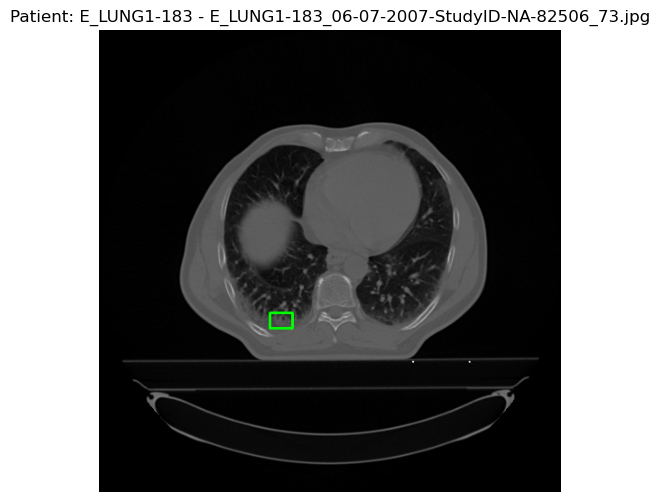

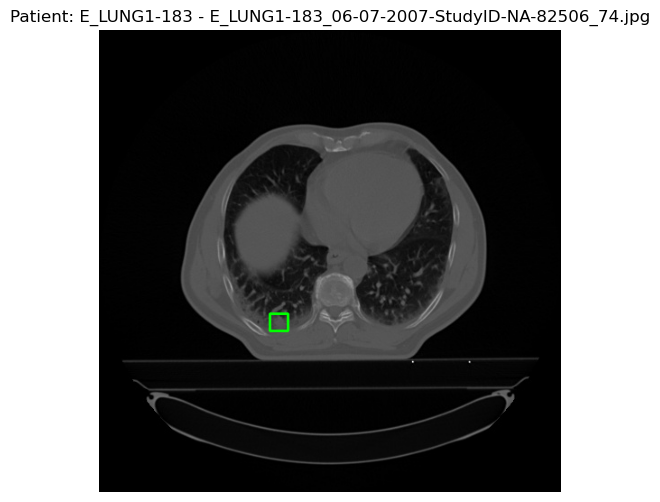

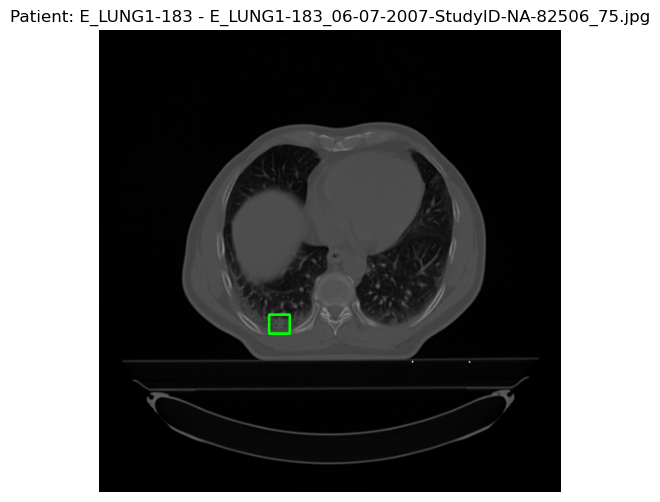

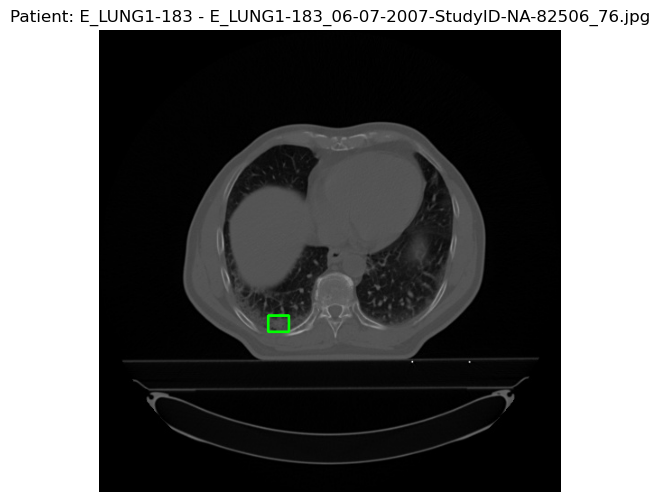

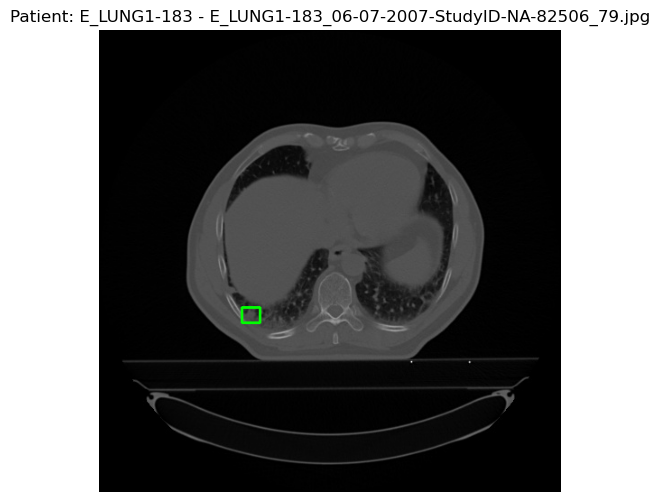

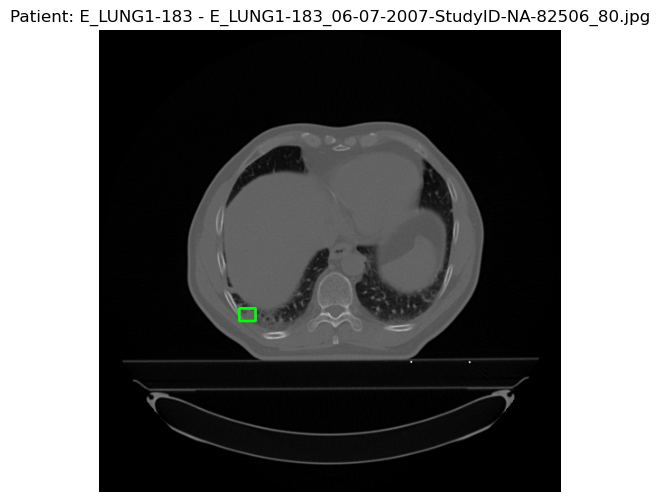

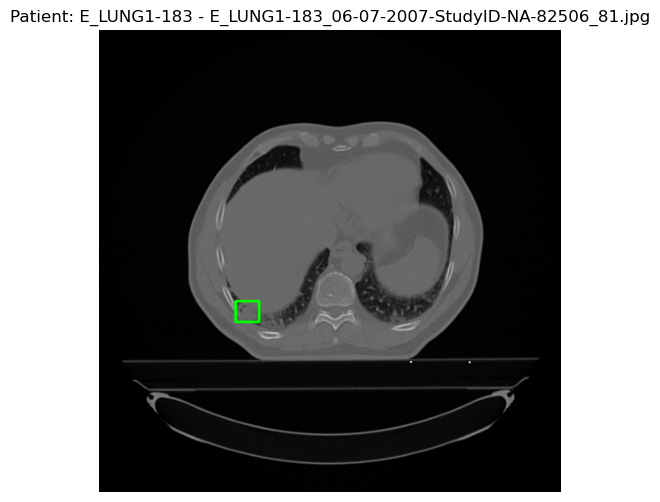

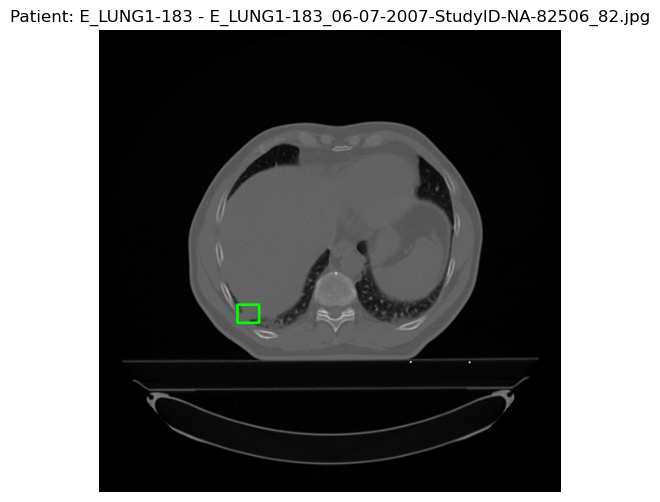

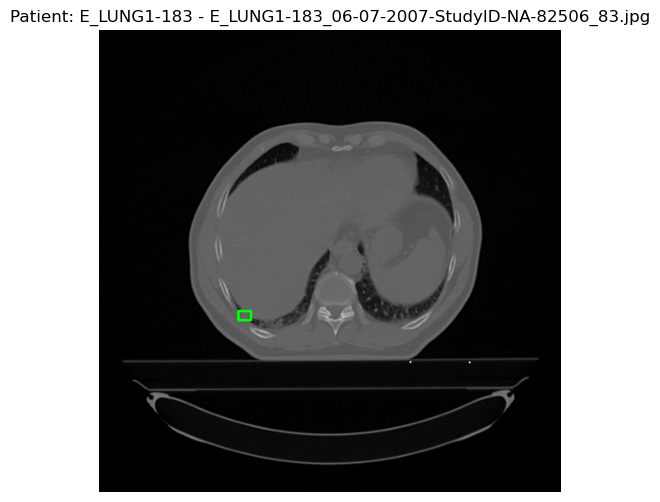

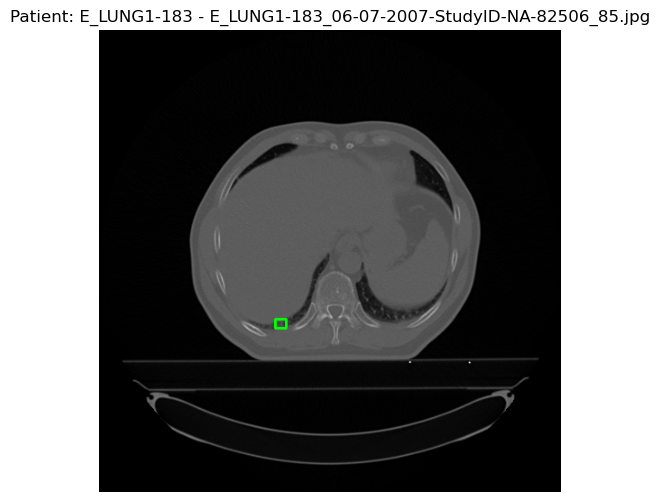

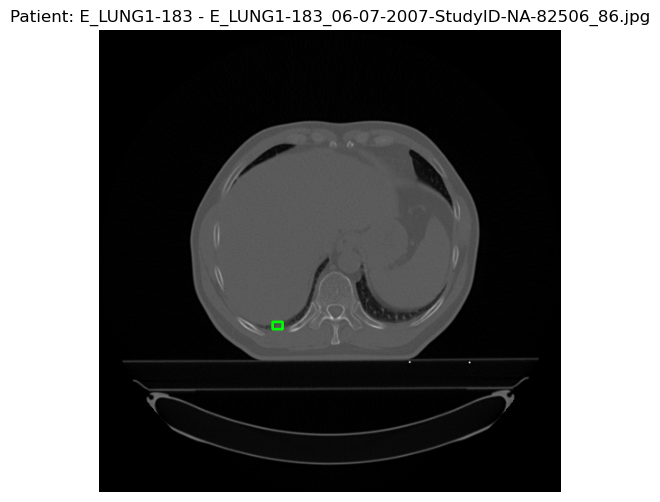

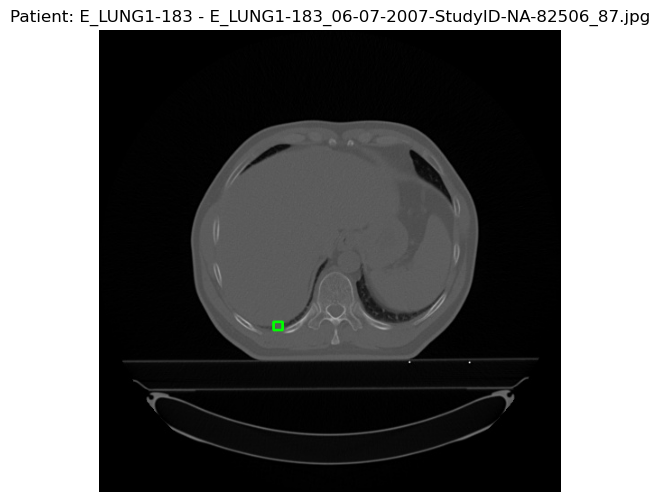

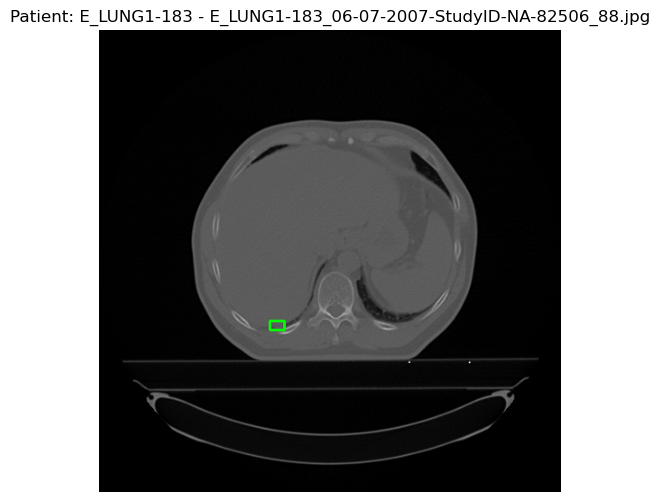

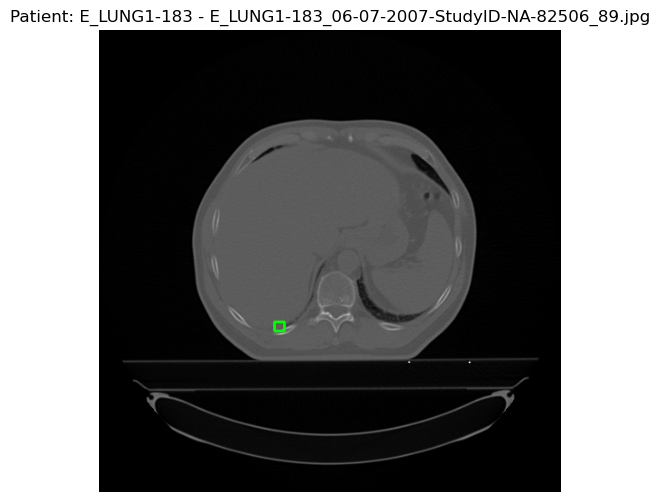

In [48]:
# Define paths
image_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

def load_yolo_labels(label_path):
    """Loads YOLO format bounding boxes from a text file."""
    bboxes = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, width, height = map(float, parts)
                bboxes.append((x_center, y_center, width, height))
    return bboxes

def draw_bboxes(image_path, label_path):
    """Loads image and labels, then draws bounding boxes."""
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    if not os.path.exists(label_path):
        return None  # Skip if label file does not exist
    
    bboxes = load_yolo_labels(label_path)

    # Draw bounding boxes
    for x_center, y_center, width, height in bboxes:
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)
        
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    return image

def display_all_images_for_patient(image_dir, label_dir, patient_id):
    """Displays all annotated images for a selected patient."""
    patient_images = sorted([f for f in os.listdir(image_dir) if f.startswith(patient_id) and f.endswith(".jpg")])
    
    if not patient_images:
        print(f"No images found for patient {patient_id}")
        return
    
    for image_filename in patient_images:
        image_path = os.path.join(image_dir, image_filename)
        label_filename = image_filename.replace(".jpg", ".txt")
        label_path = os.path.join(label_dir, label_filename)
        
        annotated_image = draw_bboxes(image_path, label_path)
        if annotated_image is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Patient: {patient_id} - {image_filename}")
            plt.axis("off")
            plt.show()

# Run the display function for a selected patient
selected_patient = "E_LUNG1-183"  # Change this to select a different patient
display_all_images_for_patient(image_dir, label_dir, selected_patient)


### Demografic Data

In [97]:
df = pd.read_csv('/Users/catarinasilva/Desktop/NSCLC data/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv')

In [34]:
df.head()

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


In [98]:
df.columns

Index(['PatientID', 'age', 'clinical.T.Stage', 'Clinical.N.Stage',
       'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender',
       'Survival.time', 'deadstatus.event'],
      dtype='object')

In [36]:
df[df['Histology'].isin(['nos', np.nan])]

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
12,LUNG1-013,65.3635,2.0,0,0,I,nos,male,3614,1
15,LUNG1-016,79.1129,2.0,0,0,I,nos,male,101,1
18,LUNG1-019,74.8200,2.0,0,0,I,nos,male,336,1
19,LUNG1-020,76.9692,2.0,3,0,IIIb,NaN,male,139,1
20,LUNG1-021,54.6475,3.0,3,0,IIIb,NaN,male,326,1
...,...,...,...,...,...,...,...,...,...,...
350,LUNG1-351,52.6434,4.0,2,0,IIIb,nos,female,463,1
352,LUNG1-353,78.3080,2.0,0,0,I,NaN,male,182,1
393,LUNG1-394,72.2219,1.0,0,0,I,NaN,male,344,1
401,LUNG1-402,68.6932,4.0,0,0,IIIb,NaN,male,1617,1


In [102]:
df = df[~df['Histology'].isin(['nos', np.nan, 'adenocarcinoma'])]

In [103]:
df.shape

(266, 10)

In [104]:
df['Histology'].value_counts()

Histology
squamous cell carcinoma    152
large cell                 114
Name: count, dtype: int64

In [105]:
total_observations = len(df)
nan_info_list = []

for column in df.columns:
    nan_count = df[column].isna().sum()
    nan_percentage = (nan_count / total_observations) * 100
    nan_info_list.append({'Column Name': column,
                          'NaN Count': nan_count,
                          'Percentage of NaNs': f"{nan_percentage:.2f}%",
                          'Total Observations': total_observations})

nan_info = pd.DataFrame(nan_info_list)

display(nan_info)

,Column Name,NaN Count,Percentage of NaNs,Total Observations
0,PatientID,0,0.00%,266
1,age,7,2.63%,266
2,clinical.T.Stage,0,0.00%,266
3,Clinical.N.Stage,0,0.00%,266
4,Clinical.M.Stage,0,0.00%,266
5,Overall.Stage,1,0.38%,266
6,Histology,0,0.00%,266
7,gender,0,0.00%,266
8,Survival.time,0,0.00%,266
9,deadstatus.event,0,0.00%,266


In [106]:
df.isna().sum()

PatientID           0
age                 7
clinical.T.Stage    0
Clinical.N.Stage    0
Clinical.M.Stage    0
Overall.Stage       1
Histology           0
gender              0
Survival.time       0
deadstatus.event    0
dtype: int64

In [65]:
rows_with_nan = df[df[['Overall.Stage', 'age']].isna().any(axis=1)]

display(rows_with_nan)

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
271,LUNG1-272,60.1396,5.0,2,0,NaN,large cell,male,288,1
274,LUNG1-275,NaN,2.0,3,0,IIIb,large cell,male,173,1
298,LUNG1-299,NaN,1.0,0,0,IIIb,squamous cell carcinoma,male,1005,1
302,LUNG1-303,NaN,2.0,0,0,I,large cell,male,24,1
307,LUNG1-308,NaN,2.0,1,0,II,large cell,female,213,1
338,LUNG1-339,NaN,4.0,2,0,IIIb,squamous cell carcinoma,male,120,1
340,LUNG1-341,NaN,2.0,0,0,I,squamous cell carcinoma,male,1157,1
348,LUNG1-349,NaN,2.0,1,0,II,adenocarcinoma,male,183,1
353,LUNG1-354,NaN,1.0,2,0,IIIa,large cell,female,617,1
384,LUNG1-385,NaN,2.0,0,0,II,adenocarcinoma,male,936,1


In [108]:
df.describe()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Survival.time,deadstatus.event
count,259.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,68.813100,2.624060,1.443609,0.022556,955.834586,0.894737
std,10.161052,1.109829,1.196937,0.259642,976.612993,0.307471
min,33.684900,1.000000,0.000000,0.000000,10.000000,0.000000
25%,61.785700,2.000000,0.000000,0.000000,258.000000,1.000000
50%,69.103400,2.000000,2.000000,0.000000,551.000000,1.000000
75%,76.724200,4.000000,2.000000,0.000000,1361.000000,1.000000
max,91.704300,5.000000,4.000000,3.000000,4328.000000,1.000000


In [80]:
df.describe(include='object')

,PatientID,Overall.Stage,Histology,gender
count,422,421,380,422
unique,422,4,4,2
top,LUNG1-001,IIIb,squamous cell carcinoma,male
freq,1,176,152,290


In [84]:
df['Histology'].value_counts()

Histology
squamous cell carcinoma    152
large cell                 114
nos                         63
adenocarcinoma              51
Name: count, dtype: int64

In [88]:
df['clinical.T.Stage'].value_counts()

clinical.T.Stage
2.0    156
4.0    117
1.0     93
3.0     53
5.0      2
Name: count, dtype: int64

In [89]:
df['Clinical.N.Stage'].value_counts()

Clinical.N.Stage
0    170
2    141
3     85
1     23
4      3
Name: count, dtype: int64

In [91]:
df['Clinical.M.Stage'].value_counts()

Clinical.M.Stage
0    417
3      4
1      1
Name: count, dtype: int64

In [93]:
df['Overall.Stage'].value_counts()

Overall.Stage
IIIb    176
IIIa    112
I        93
II       40
Name: count, dtype: int64

In [127]:
# List of selected PatientIDs for class G
selected_patients_g = [
    'LUNG1-007', 'LUNG1-010', 'LUNG1-014', 'LUNG1-027', 'LUNG1-050', 'LUNG1-061', 'LUNG1-063', 'LUNG1-064', 
    'LUNG1-078', 'LUNG1-082', 'LUNG1-086', 'LUNG1-098', 'LUNG1-122', 'LUNG1-135', 'LUNG1-145', 'LUNG1-146', 
    'LUNG1-150', 'LUNG1-167', 'LUNG1-202', 'LUNG1-206', 'LUNG1-222', 'LUNG1-253', 'LUNG1-264', 'LUNG1-266', 
    'LUNG1-295', 'LUNG1-296', 'LUNG1-302', 'LUNG1-321', 'LUNG1-325', 'LUNG1-326', 'LUNG1-329', 'LUNG1-334', 
    'LUNG1-339', 'LUNG1-346', 'LUNG1-347', 'LUNG1-355', 'LUNG1-356', 'LUNG1-358', 'LUNG1-359', 'LUNG1-362', 
    'LUNG1-365', 'LUNG1-366', 'LUNG1-369', 'LUNG1-371', 'LUNG1-374', 'LUNG1-378', 'LUNG1-379', 'LUNG1-380', 
    'LUNG1-383', 'LUNG1-386', 'LUNG1-389', 'LUNG1-391', 'LUNG1-399', 'LUNG1-404', 'LUNG1-413', 'LUNG1-420'
]

# Filter the dataset to include:
filtered_df = df[(df['PatientID'].isin(selected_patients_g)) | (df['Histology'] == 'large cell')]

# Display the filtered DataFrame
display(filtered_df)

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
6,LUNG1-007,81.5288,2.0,2,0,IIIa,squamous cell carcinoma,male,137,1
9,LUNG1-010,71.0554,4.0,3,0,IIIb,squamous cell carcinoma,female,2119,0
13,LUNG1-014,66.7707,4.0,0,0,IIIb,squamous cell carcinoma,male,1247,1
...,...,...,...,...,...,...,...,...,...,...
390,LUNG1-391,60.0822,2.0,0,0,I,squamous cell carcinoma,female,256,1
398,LUNG1-399,77.7973,1.0,2,0,IIIa,squamous cell carcinoma,female,2835,0
403,LUNG1-404,74.2356,3.0,2,0,IIIa,squamous cell carcinoma,male,280,1
412,LUNG1-413,60.5315,4.0,2,0,IIIb,squamous cell carcinoma,female,246,1


In [128]:
total_observations = len(filtered_df)
nan_info_list = []

for column in filtered_df.columns:
    nan_count = filtered_df[column].isna().sum()
    nan_percentage = (nan_count / total_observations) * 100
    nan_info_list.append({'Column Name': column,
                          'NaN Count': nan_count,
                          'Percentage of NaNs': f"{nan_percentage:.2f}%",
                          'Total Observations': total_observations})

nan_info = pd.DataFrame(nan_info_list)

display(nan_info)

,Column Name,NaN Count,Percentage of NaNs,Total Observations
0,PatientID,0,0.00%,170
1,age,5,2.94%,170
2,clinical.T.Stage,0,0.00%,170
3,Clinical.N.Stage,0,0.00%,170
4,Clinical.M.Stage,0,0.00%,170
5,Overall.Stage,1,0.59%,170
6,Histology,0,0.00%,170
7,gender,0,0.00%,170
8,Survival.time,0,0.00%,170
9,deadstatus.event,0,0.00%,170


In [129]:
filtered_df.describe()

,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Survival.time,deadstatus.event
count,165.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,67.681981,2.482353,1.594118,0.035294,1071.370588,0.870588
std,10.231576,1.152427,1.194153,0.324432,1041.800460,0.336647
min,33.684900,1.000000,0.000000,0.000000,10.000000,0.000000
25%,60.695900,2.000000,0.000000,0.000000,265.250000,1.000000
50%,68.106800,2.000000,2.000000,0.000000,637.000000,1.000000
75%,74.929500,4.000000,2.750000,0.000000,1595.750000,1.000000
max,91.704300,5.000000,4.000000,3.000000,4328.000000,1.000000


In [130]:
filtered_df.describe(include='object')

,PatientID,Overall.Stage,Histology,gender
count,170,169,170,170
unique,170,4,2,2
top,LUNG1-001,IIIb,large cell,male
freq,1,76,114,106


In [131]:
filtered_df['Histology'].value_counts()

Histology
large cell                 114
squamous cell carcinoma     56
Name: count, dtype: int64

## Preprocessing images + image sampling

In [27]:
import os
import pandas as pd

# Define file paths
image_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

# Map histology type to prefix
histology_prefix = {
    "squamous cell carcinoma": "G",
    "large cell": "E",
    "adenocarcinoma": "A"
}

# Convert dataframe to a dictionary for fast lookup
patient_to_histology = df.set_index("PatientID")["Histology"].to_dict()

def rename_files_in_folder(folder_path, patient_to_histology, histology_prefix):
    """Renames files in the folder by adding the correct histology letter prefix."""
    for filename in os.listdir(folder_path):
        # Extract patient ID from the file name (first part before "_")
        patient_id = filename.split("_")[0]

        # Get corresponding histology and prefix
        histology = patient_to_histology.get(patient_id, None)
        if histology in histology_prefix:
            prefix = histology_prefix[histology]
            new_filename = f"{prefix}_{filename}"

            # Rename file
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} → {new_filename}")

# Rename images and labels
rename_files_in_folder(image_dir, patient_to_histology, histology_prefix)
rename_files_in_folder(label_dir, patient_to_histology, histology_prefix)

print("Renaming complete!")

Renamed: LUNG1-230_01-23-2008-NA-NA-32295_30.jpg → A_LUNG1-230_01-23-2008-NA-NA-32295_30.jpg
Renamed: LUNG1-008_01-01-2014-StudyID-NA-52421_41.jpg → A_LUNG1-008_01-01-2014-StudyID-NA-52421_41.jpg
Renamed: LUNG1-316_11-28-2008-NA-NA-76361_74.jpg → E_LUNG1-316_11-28-2008-NA-NA-76361_74.jpg
Renamed: LUNG1-289_08-23-2008-StudyID-NA-97557_19.jpg → E_LUNG1-289_08-23-2008-StudyID-NA-97557_19.jpg
Renamed: LUNG1-018_01-01-2014-StudyID-NA-55796_66.jpg → G_LUNG1-018_01-01-2014-StudyID-NA-55796_66.jpg
Renamed: LUNG1-018_01-01-2014-StudyID-NA-55796_72.jpg → G_LUNG1-018_01-01-2014-StudyID-NA-55796_72.jpg
Renamed: LUNG1-179_05-13-2007-StudyID-NA-86662_28.jpg → E_LUNG1-179_05-13-2007-StudyID-NA-86662_28.jpg
Renamed: LUNG1-196_11-10-2007-StudyID-NA-60648_57.jpg → E_LUNG1-196_11-10-2007-StudyID-NA-60648_57.jpg
Renamed: LUNG1-130_08-14-2006-StudyID-NA-58337_66.jpg → A_LUNG1-130_08-14-2006-StudyID-NA-58337_66.jpg
Renamed: LUNG1-409_06-17-2010-NA-NA-58404_40.jpg → G_LUNG1-409_06-17-2010-NA-NA-58404_40.jpg


In [42]:
import os
from collections import Counter

# Define file paths
image_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

# Define prefixes for histology types
histology_prefixes = ["G", "E", "A"]

def count_files_by_prefix(folder_path, prefixes):
    """Counts how many files in a folder start with each prefix."""
    counts = Counter()
    
    for filename in os.listdir(folder_path):
        for prefix in prefixes:
            if filename.startswith(prefix):
                counts[prefix] += 1

    return counts

# Count images and labels
image_counts = count_files_by_prefix(image_dir, histology_prefixes)
label_counts = count_files_by_prefix(label_dir, histology_prefixes)

# Display results
print("Image File Counts by Histopatology diagnosis:")
for prefix, count in image_counts.items():
    print(f"  {prefix}: {count} images")

print("\nLabel File Counts by Histopatology diagnosis:")
for prefix, count in label_counts.items():
    print(f"  {prefix}: {count} labels")


Image File Counts by Histopatology diagnosis:
  E: 2026 images
  G: 2735 images
  A: 952 images

Label File Counts by Histopatology diagnosis:
  E: 2026 labels
  A: 952 labels
  G: 2735 labels


In [45]:
import os
from collections import Counter

# Define file paths
image_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

# Define prefixes for histology types
histology_prefixes = ["G", "E", "A"]

def count_files_and_patients(folder_path, prefixes):
    """Counts the number of files and unique patients per histology prefix."""
    file_counts = Counter()
    patient_counts = {prefix: set() for prefix in prefixes}  # Use sets to track unique patients
    
    for filename in os.listdir(folder_path):
        for prefix in prefixes:
            if filename.startswith(prefix):
                file_counts[prefix] += 1
                patient_id = filename.split("_")[1]  # Extract patient ID
                patient_counts[prefix].add(patient_id)

    # Convert patient sets to counts
    patient_counts = {prefix: len(patients) for prefix, patients in patient_counts.items()}
    
    return file_counts, patient_counts

# Count images and unique patients in images
image_counts, image_patient_counts = count_files_and_patients(image_dir, histology_prefixes)

# Count labels and unique patients in labels
label_counts, label_patient_counts = count_files_and_patients(label_dir, histology_prefixes)

# Display results
print("Image & Label Counts by Histology Prefix:")
for prefix in histology_prefixes:
    print(f"  {prefix}: {image_counts.get(prefix, 0)} images, {label_counts.get(prefix, 0)} labels")

print("\nUnique Patient Counts by Histology Prefix (Images & Labels):")
for prefix in histology_prefixes:
    print(f"  {prefix}: {image_patient_counts.get(prefix, 0)} patients in images, {label_patient_counts.get(prefix, 0)} patients in labels")


Image & Label Counts by Histology Prefix:
  G: 2735 images, 2735 labels
  E: 2026 images, 2026 labels
  A: 952 images, 952 labels

Unique Patient Counts by Histology Prefix (Images & Labels):
  G: 152 patients in images, 152 patients in labels
  E: 114 patients in images, 114 patients in labels
  A: 51 patients in images, 51 patients in labels


In [46]:
import os

# Define label directory path
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

# Define mapping for histology prefix to class number
histology_class_map = {
    "A": "0",  # Adenocarcinoma
    "E": "2",  # Large cell
    "G": "3"   # Squamous cell carcinoma
}

def update_label_files(label_dir, histology_class_map):
    """Updates YOLO label files by replacing the first number with the correct class."""
    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            histology_prefix = filename[0]  # Extract the first letter
            
            if histology_prefix in histology_class_map:
                class_number = histology_class_map[histology_prefix]
                
                label_path = os.path.join(label_dir, filename)
                
                # Read and modify the label file
                with open(label_path, "r") as f:
                    lines = f.readlines()

                # Replace first number in each line
                updated_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:  # Ensure correct YOLO format
                        parts[0] = class_number  # Replace class ID
                        updated_lines.append(" ".join(parts))

                # Write updated lines back to the file
                with open(label_path, "w") as f:
                    f.write("\n".join(updated_lines) + "\n")

                print(f"Updated: {filename}")

# Run the function to update labels
update_label_files(label_dir, histology_class_map)

print("All label files updated successfully!")

Updated: E_LUNG1-124_09-28-2006-StudyID-NA-06637_44.txt
Updated: A_LUNG1-052_01-01-2014-StudyID-NA-48653_81.txt
Updated: G_LUNG1-369_02-25-2010-NA-NA-41022_33.txt
Updated: G_LUNG1-193_07-26-2007-StudyID-NA-31252_45.txt
Updated: G_LUNG1-146_12-10-2006-StudyID-NA-54933_64.txt
Updated: G_LUNG1-376_02-27-2010-NA-NA-88135_56.txt
Updated: E_LUNG1-342_07-05-2009-StudyID-NA-33638_62.txt
Updated: G_LUNG1-146_12-10-2006-StudyID-NA-54933_70.txt
Updated: A_LUNG1-200_09-02-2007-NA-NA-56233_33.txt
Updated: G_LUNG1-296_10-03-2008-StudyID-NA-14251_58.txt
Updated: G_LUNG1-376_02-27-2010-NA-NA-88135_42.txt
Updated: E_LUNG1-140_01-01-2014-StudyID-NA-75276_36.txt
Updated: G_LUNG1-193_07-26-2007-StudyID-NA-31252_51.txt
Updated: A_LUNG1-052_01-01-2014-StudyID-NA-48653_95.txt
Updated: E_LUNG1-330_04-03-2009-NA-NA-46378_36.txt
Updated: E_LUNG1-124_09-28-2006-StudyID-NA-06637_50.txt
Updated: E_LUNG1-283_08-04-2008-StudyID-NA-17254_48.txt
Updated: E_LUNG1-038_01-01-2014-StudyID-NA-11498_138.txt
Updated: G_LUNG1

In [111]:
selected_patients

{'G': [('LUNG1-386', 3),
  ('LUNG1-027', 3),
  ('LUNG1-167', 3),
  ('LUNG1-086', 4),
  ('LUNG1-098', 4),
  ('LUNG1-050', 4),
  ('LUNG1-325', 6),
  ('LUNG1-082', 6),
  ('LUNG1-296', 6),
  ('LUNG1-359', 6),
  ('LUNG1-321', 7),
  ('LUNG1-347', 7),
  ('LUNG1-061', 7),
  ('LUNG1-135', 7),
  ('LUNG1-253', 8),
  ('LUNG1-399', 8),
  ('LUNG1-404', 8),
  ('LUNG1-346', 8),
  ('LUNG1-369', 8),
  ('LUNG1-371', 8),
  ('LUNG1-295', 8),
  ('LUNG1-391', 8),
  ('LUNG1-150', 8),
  ('LUNG1-078', 9),
  ('LUNG1-365', 9),
  ('LUNG1-146', 9),
  ('LUNG1-334', 9),
  ('LUNG1-266', 9),
  ('LUNG1-379', 9),
  ('LUNG1-329', 10),
  ('LUNG1-206', 10),
  ('LUNG1-064', 10),
  ('LUNG1-122', 10),
  ('LUNG1-007', 10),
  ('LUNG1-380', 10),
  ('LUNG1-326', 10),
  ('LUNG1-356', 10),
  ('LUNG1-420', 11),
  ('LUNG1-202', 11),
  ('LUNG1-014', 11),
  ('LUNG1-063', 12),
  ('LUNG1-362', 12),
  ('LUNG1-413', 12),
  ('LUNG1-383', 12),
  ('LUNG1-302', 12),
  ('LUNG1-389', 12),
  ('LUNG1-339', 12),
  ('LUNG1-374', 12),
  ('LUNG1-222', 

In [110]:
import os
import shutil
from collections import defaultdict

# Define file paths
image_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_images"
label_dir = "/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels"

# Define output directories
output_image_dir = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLO 2datasets/images"
output_label_dir = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLO 2datasets/labels"

# Define prefixes for histology types
histology_prefixes = ["G"]

# Define the target number of images per class
TARGET_IMAGES = 1000  # Change this to your desired number

def get_patient_images(folder_path, prefixes):
    """Maps patients to their images per histology prefix."""
    patient_images = {prefix: defaultdict(list) for prefix in prefixes}

    for filename in os.listdir(folder_path):
        for prefix in prefixes:
            if filename.startswith(prefix):
                patient_id = filename.split("_")[1]  # Extract patient ID
                patient_images[prefix][patient_id].append(filename)

    return patient_images

def sample_patients_by_image_count(patient_images, target_images):
    """Selects patients iteratively until the total number of images reaches the target."""
    selected_patients = {prefix: [] for prefix in patient_images.keys()}  # List to store patient IDs
    selected_images = {prefix: [] for prefix in patient_images.keys()}  # List to store images

    for prefix, patients in patient_images.items():
        # Sort patients by number of images (ascending order)
        sorted_patients = sorted(patients.items(), key=lambda x: len(x[1]))

        total_images = 0
        for patient_id, images in sorted_patients:
            if total_images >= target_images:
                break  # Stop when reaching the target
            
            selected_patients[prefix].append((patient_id, len(images)))  # Store patient ID & image count
            selected_images[prefix].extend(images)
            total_images += len(images)

    return selected_patients, selected_images

def copy_sampled_files(selected_images, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
    """Copies sampled images and labels to the target directory."""
    os.makedirs(dest_image_dir, exist_ok=True)
    os.makedirs(dest_label_dir, exist_ok=True)

    for prefix, images in selected_images.items():
        for image_file in images:
            image_path = os.path.join(src_image_dir, image_file)
            label_file = image_file.replace(".jpg", ".txt")  # Get corresponding label filename
            label_path = os.path.join(src_label_dir, label_file)

            # Copy image
            if os.path.exists(image_path):
                shutil.copy(image_path, dest_image_dir)

            # Copy corresponding label
            if os.path.exists(label_path):
                shutil.copy(label_path, dest_label_dir)

# Get mapping of patients to their images
patient_images = get_patient_images(image_dir, histology_prefixes)

# Sample patients based on image count
selected_patients, selected_images = sample_patients_by_image_count(patient_images, TARGET_IMAGES)

# Copy sampled images and labels to the target directories
copy_sampled_files(selected_images, image_dir, label_dir, output_image_dir, output_label_dir)

# Display results
print("\n**Selected Patients and Images Per Histology Type**")
for prefix in histology_prefixes:
    print(f"\n{prefix}:")
    print(f"  Patients Selected: {len(selected_patients[prefix])}")
    print(f"  Images Selected: {len(selected_images[prefix])}")
    print("  Patient List (Patient ID | Image Count):")
    for patient_id, img_count in selected_patients[prefix]:
        print(f"    - {patient_id}: {img_count} images")

print("\nSampled images and labels have been successfully copied to the specified directories!")


**Selected Patients and Images Per Histology Type**

G:
  Patients Selected: 86
  Images Selected: 1007
  Patient List (Patient ID | Image Count):
    - LUNG1-386: 3 images
    - LUNG1-027: 3 images
    - LUNG1-167: 3 images
    - LUNG1-086: 4 images
    - LUNG1-098: 4 images
    - LUNG1-050: 4 images
    - LUNG1-325: 6 images
    - LUNG1-082: 6 images
    - LUNG1-296: 6 images
    - LUNG1-359: 6 images
    - LUNG1-321: 7 images
    - LUNG1-347: 7 images
    - LUNG1-061: 7 images
    - LUNG1-135: 7 images
    - LUNG1-253: 8 images
    - LUNG1-399: 8 images
    - LUNG1-404: 8 images
    - LUNG1-346: 8 images
    - LUNG1-369: 8 images
    - LUNG1-371: 8 images
    - LUNG1-295: 8 images
    - LUNG1-391: 8 images
    - LUNG1-150: 8 images
    - LUNG1-078: 9 images
    - LUNG1-365: 9 images
    - LUNG1-146: 9 images
    - LUNG1-334: 9 images
    - LUNG1-266: 9 images
    - LUNG1-379: 9 images
    - LUNG1-329: 10 images
    - LUNG1-206: 10 images
    - LUNG1-064: 10 images
    - LUNG1-122: 

In [120]:
import os
import shutil
import random
from collections import defaultdict

def get_patient_images(folder_path, prefix):
    """Organiza imagens por paciente para um determinado prefixo."""
    patient_images = defaultdict(list)
    for filename in os.listdir(folder_path):
        if filename.startswith(prefix):
            patient_id = filename.split("_")[1]  # Extrai o ID do paciente
            patient_images[patient_id].append(filename)
    return patient_images

def sample_patients(patient_images, target_images):
    """Seleciona pacientes até atingir o número desejado de imagens."""
    selected_patients = []
    selected_images = []
    sorted_patients = sorted(patient_images.items(), key=lambda x: len(x[1]))
    total_images = 0
    
    for patient_id, images in sorted_patients:
        if total_images >= target_images:
            break
        selected_patients.append(patient_id)
        selected_images.extend(images)
        total_images += len(images)
    
    return selected_patients, selected_images

def split_data(selected_patients, patient_images):
    """Divide os pacientes em conjuntos de treino, validação e teste (70%-15%-15%)."""
    random.shuffle(selected_patients)
    num_patients = len(selected_patients)
    
    train_split = int(0.7 * num_patients)
    val_split = int(0.15 * num_patients)
    
    train_patients = selected_patients[:train_split]
    val_patients = selected_patients[train_split:train_split + val_split]
    test_patients = selected_patients[train_split + val_split:]
    
    return {
        "train": [img for p in train_patients for img in patient_images[p]],
        "val": [img for p in val_patients for img in patient_images[p]],
        "test": [img for p in test_patients for img in patient_images[p]]
    }

def copy_files(data_split, src_image_dir, src_label_dir, dest_base_dir, prefix):
    """Copia imagens e rótulos para seus respectivos diretórios."""
    for split, images in data_split.items():
        split_dir = os.path.join(dest_base_dir, f"split_patient_{prefix}", split)
        image_dest = os.path.join(split_dir, "images")
        label_dest = os.path.join(split_dir, "labels")
        os.makedirs(image_dest, exist_ok=True)
        os.makedirs(label_dest, exist_ok=True)
        
        for image_file in images:
            image_path = os.path.join(src_image_dir, image_file)
            label_file = image_file.replace(".jpg", ".txt")
            label_path = os.path.join(src_label_dir, label_file)
            
            if os.path.exists(image_path):
                shutil.copy(image_path, image_dest)
            if os.path.exists(label_path):
                shutil.copy(label_path, label_dest)

def main(base_image_dir, base_label_dir, output_dir, prefix, num_images):
    patient_images = get_patient_images(base_image_dir, prefix)
    selected_patients, _ = sample_patients(patient_images, num_images)
    data_split = split_data(selected_patients, patient_images)
    copy_files(data_split, base_image_dir, base_label_dir, output_dir, prefix)
    print("Processo concluído com sucesso!")

# Exemplo de uso
main(
    base_image_dir="/Users/catarinasilva/Desktop/NSCLC data/YOLO_images",
    base_label_dir="/Users/catarinasilva/Desktop/NSCLC data/YOLO_labels",
    output_dir="/Users/catarinasilva/Desktop/coiso",
    prefix="G",  # Escolha 'A', 'G' ou 'E'
    num_images=500  # Quantidade desejada de imagens
)


Processo concluído com sucesso!
